In [1]:
#pip install transformers datasets

In [2]:
from datasets import load_dataset 

imagenette = load_dataset(
    'frgfm/imagenette', 
    'full_size', 
    split='train', 
    ignore_verifications=False
)

imagenette

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to C:\Users\zamans\.cache\huggingface\datasets\frgfm___imagenette\full_size\1.0.0\38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

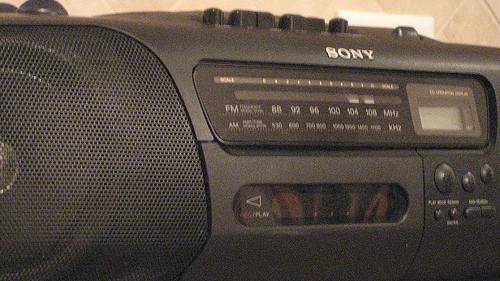

In [3]:
imagenette[0]['image']

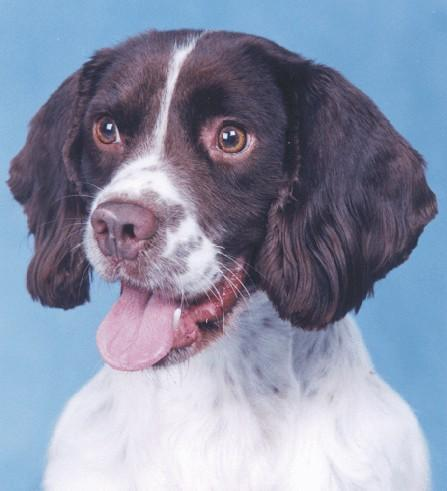

In [4]:
imagenette[6494]['image']

In [6]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel 
import torch 

device = 'cuda' if torch.cuda.is_available() else 'cpu' #('mps' if torch.backends.mps.is_available() else 'cpu')
model_id = 'openai/clip-vit-base-patch32'

tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

##### Text Embeddings

In [10]:
prompt = 'a dog in the snow'
inputs = tokenizer(prompt, return_tensors='pt')
inputs

{'input_ids': tensor([[49406,   320,  1929,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [22]:
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

##### Image Embeddings

In [8]:
image = processor(
    text=None, 
    images=imagenette[0]['image'], 
    return_tensors='pt', 
    padding=True
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

C:\Users\zamans\AppData\Local\Temp\ipykernel_12912\535637828.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2318.)
  plt.imshow(image.squeeze(0).T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


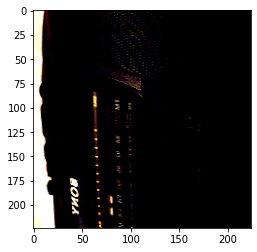

In [12]:
import matplotlib.pyplot as plt 
plt.imshow(image.squeeze(0).T)

In [13]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [14]:
import numpy as np

np.random.seed(0)
sample_idx = np.random.randint(0, len(imagenette), 100).tolist()
images = [imagenette[i]['image'] for i in sample_idx]

In [28]:
from tqdm.auto import tqdm

batch_size = 16 
image_arr = None 

for i in tqdm(range(0, len(images), batch_size)):
    batch = images[i:i+batch_size]
    batch = processor(
        text=None, 
        images=batch, 
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)

    batch_emb = model.get_image_features(pixel_values=batch)
    #convet to numpy
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
    

image_arr.shape

  0%|          | 0/7 [00:00<?, ?it/s]

(100, 512)

In [29]:
image_arr.min(), image_arr.max()

(-7.994916, 3.1525078)

In [30]:
image_arr = image_arr / np.linalg.norm(image_arr, axis=0)
image_arr.min(), image_arr.max()

(-0.38183686, 0.49752793)

In [23]:
text_emb = text_emb.cpu().detach().numpy()
scores = np.dot(text_emb, image_arr.T)
scores.shape

(1, 100)

In [31]:
top_k = 5
#get the top_k indices for most similar images 
idx = np.argsort(-scores[0])[:top_k]
idx

array([71, 24, 86, 76, 85], dtype=int64)

71: 4.705071926116943


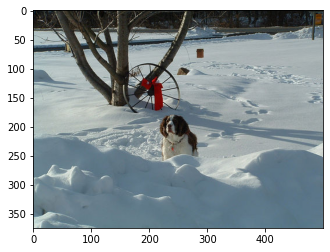

24: 3.656616687774658


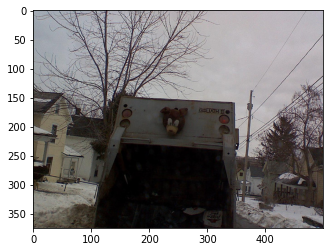

86: 3.2524895668029785


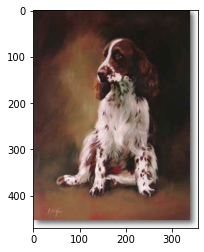

76: 3.1241953372955322


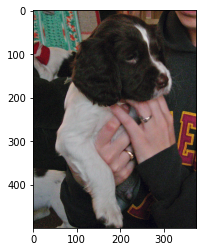

85: 2.82820987701416


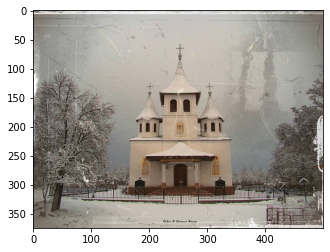

In [32]:
import matplotlib.pyplot as plt 
for i in idx:
    print(f'{i}: {scores[0][i]}')
    plt.imshow(images[i], cmap='gray')
    plt.show()